# CSE-CIC-IDS 2017

In [23]:
model_id = "cnn8-10deep"

In [2]:
import numpy as np
np.random.seed(42)
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import glob, time, os

import keras

Using TensorFlow backend.
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Xetrov\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Us

In [3]:
NOTEBOOK_PATH = "C:/Users/Xetrov/Desktop/SciFair20/Code/"

In [4]:
x_scaled = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_scaled_powertransform.csv")

In [5]:
y_df_enc = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_all_binary.csv")

# Reshape into images

In [6]:
x_img = x_scaled.to_numpy().reshape((len(x_scaled), 4, 17))

In [7]:
x_img = np.expand_dims(x_img, -1)

# Split data into train and test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_valtest, y_train, y_valtest = train_test_split(x_img, y_df_enc, test_size = 0.4, random_state = 42)

x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, random_state = 42)

del x_train
del y_train
del x_valtest 
del y_valtest

# Read ADASYN data

In [10]:
x_train_res = pd.read_csv(NOTEBOOK_PATH + "IDS2017/x_adasyn_binary.csv")

In [11]:
y_train_res = pd.read_csv(NOTEBOOK_PATH + "IDS2017/y_adasyn_binary.csv")['IsAttack']

In [12]:
x_train_resimg = np.expand_dims(x_train_res.to_numpy().reshape((len(x_train_res), 4, 17)), -1)

# Train model

In [13]:
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, Dropout, InputLayer, Conv2D, Flatten
from keras.optimizers import SGD, Adam

In [24]:
def addDenseBlock(model, units, **params):
    model.add(Dense(units=units, activation=params['hidden_activation'], input_dim=x_train_res.shape[1]))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))

def addConvBlock(model, units, **params):
    model.add(Conv2D(filters=units, kernel_size=params['kernel_size'], activation=params['hidden_activation'], padding=params['padding'],input_shape=(4,17,1)))
    if params['batch_normalization']: model.add(BatchNormalization())
    if params['dropout_rate'] > 0: model.add(Dropout(params['dropout_rate']))
        
def createModel(**in_params):
    """
    Supported parameters:
    batch_normalization - True or False
    dropout_rate - 0 to 1
    num_units - integer
    learning_rate - float
    activation_function - string
    """
    
    model = Sequential()

    # Set default values
    params = {
        'batch_normalization': True,
        'dropout_rate': 0,
        'learning_rate': 0.001,
        'hidden_activation': 'relu',
        'final_activation': 'sigmoid',
        'kernel_size': (2,2),
        'padding':'same'
    }
    
    # Replace defaults with specified parameters
    for param in in_params:
        params[param] = in_params[param]    
    
    # InputLayer causes serialization issues
#     model.add( InputLayer(input_shape = (x_train.shape[1],) ) )
    
#     for i in range(params['num_layers']):
#         addDenseBlock(model, params['num_units'], **params)

    addConvBlock(model, 64, **params)
    addConvBlock(model, 128, **params)
    addConvBlock(model, 128, **params)
    
    addConvBlock(model, 256, **params)
    addConvBlock(model, 256, **params)
    addConvBlock(model, 256, **params)
    addConvBlock(model, 256, **params)
    
    addConvBlock(model, 128, **params)
    addConvBlock(model, 128, **params)
    addConvBlock(model, 64, **params)
    
    model.add(Flatten())

    model.add(Dense(units=1, activation=params['final_activation']))

    # optim = SGD(lr=0.001, nesterov=True)
    optim = Adam(lr=params['learning_rate'])

    model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
    
#     print(params)
    
    return model

Ensure a GPU is available

In [15]:
import keras.backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Callbacks

In [25]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

def timestamp():
    return time.strftime("%m-%d-%Y, %I%M%p")

csv_callback = CSVLogger(NOTEBOOK_PATH + 'Loss Logs/%s (%s)' % (model_id, timestamp()), append=True)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta=0.0001, patience=5)

savedir = NOTEBOOK_PATH + "Models/%s/" % model_id
if not os.path.exists(savedir):
    os.makedirs(savedir)
    print("Created " + savedir)
else:
    print("Using " + savedir)

Created C:/Users/Xetrov/Desktop/SciFair20/Code/Models/cnn8-10deep/


### Training

In [28]:
import itertools

trainEpochs = 100

parameters = {'batch_size': 1000, 'batch_normalization':True, 'dropout_rate':0, 'final_activation': 'sigmoid'}

In [29]:
%%time
print(model_id)
model = createModel(**parameters)
# model = keras.models.load_model(NOTEBOOK_PATH + "Models/cnn4-adasyn-run1/cnn(4).h5")
model.summary()
model_checkpoint = ModelCheckpoint(NOTEBOOK_PATH + "Models/%s/cnn({epoch}).h5" % (model_id), monitor='val_loss')
model.fit(x_train_resimg, y_train_res, validation_data=(x_val, y_val), batch_size=parameters['batch_size'], epochs=trainEpochs, verbose=2, callbacks=[csv_callback, model_checkpoint])

cnn8-10deep
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 4, 17, 64)         320       
_________________________________________________________________
batch_normalization_35 (Batc (None, 4, 17, 64)         256       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 4, 17, 128)        32896     
_________________________________________________________________
batch_normalization_36 (Batc (None, 4, 17, 128)        512       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 4, 17, 128)        65664     
_________________________________________________________________
batch_normalization_37 (Batc (None, 4, 17, 128)        512       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 17, 256)        131328   

Epoch 58/100
 - 394s - loss: 0.0083 - acc: 0.9983 - val_loss: 0.0099 - val_acc: 0.9978
Epoch 59/100
 - 393s - loss: 0.0080 - acc: 0.9984 - val_loss: 0.0210 - val_acc: 0.9971
Epoch 60/100
 - 394s - loss: 0.0079 - acc: 0.9984 - val_loss: 0.0109 - val_acc: 0.9957
Epoch 61/100
 - 392s - loss: 0.0071 - acc: 0.9986 - val_loss: 0.0134 - val_acc: 0.9947
Epoch 62/100
 - 393s - loss: 0.0086 - acc: 0.9983 - val_loss: 0.0123 - val_acc: 0.9952
Epoch 63/100
 - 392s - loss: 0.0078 - acc: 0.9984 - val_loss: 0.0111 - val_acc: 0.9975
Epoch 64/100
 - 397s - loss: 0.0079 - acc: 0.9984 - val_loss: 0.0171 - val_acc: 0.9971
Epoch 65/100
 - 393s - loss: 0.0081 - acc: 0.9984 - val_loss: 0.0139 - val_acc: 0.9958
Epoch 66/100
 - 393s - loss: 0.0077 - acc: 0.9985 - val_loss: 0.0133 - val_acc: 0.9973
Epoch 67/100
 - 395s - loss: 0.0068 - acc: 0.9987 - val_loss: 0.0130 - val_acc: 0.9975
Epoch 68/100
 - 393s - loss: 0.0067 - acc: 0.9987 - val_loss: 0.0105 - val_acc: 0.9975
Epoch 69/100
 - 395s - loss: 0.0075 - acc: 

# Graph the losses

In [31]:
def most_recent_file(pattern):
    return max(glob.iglob(pattern, recursive=True), key=os.path.getctime)

logpath = most_recent_file(NOTEBOOK_PATH + "Loss Logs/%s**" % model_id)
log_df = pd.read_csv(logpath)
log_df['epoch'] += 1

print(logpath)

C:/Users/Xetrov/Desktop/SciFair20/Code/Loss Logs\cnn8-10deep (11-10-2019, 1100PM)


epoch       84.000000
acc          0.998808
loss         0.006039
val_acc      0.998303
val_loss     0.008070
Name: 84, dtype: float64


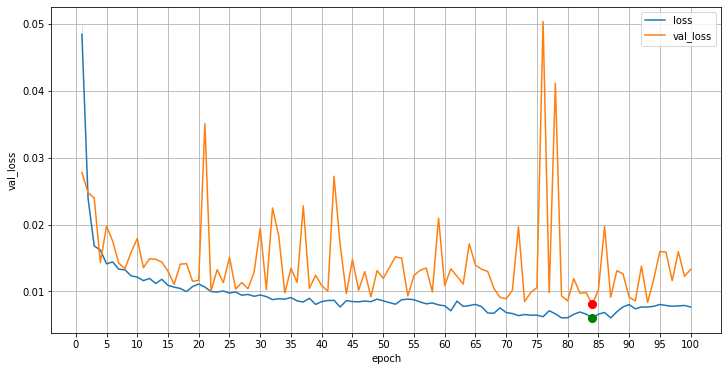

In [32]:
plot_df = log_df[:]

metric = 'loss'

plt.figure(figsize=(12,6))
sns.lineplot(x='epoch', y=metric, data=plot_df, label=metric)
sns.lineplot(x='epoch', y='val_'+metric, data=plot_df, label='val_'+metric)
plt.legend()

minEpoch = plot_df.loc[plot_df.idxmin()[metric]]
plt.plot((minEpoch['epoch']), (minEpoch[metric]), 'go', markersize=8)
minEpoch = plot_df.loc[plot_df.idxmin()['val_'+metric]]
plt.plot((minEpoch['epoch']), (minEpoch['val_'+metric]), 'ro', markersize=8)
print(minEpoch)

plt.xticks(list(range(0, plot_df['epoch'].max()+1, 5)))
# plt.yticks(list(np.arange(0.0,0.4,0.05)))

plt.grid(True)

# Validation data

In [33]:
print("Loading...")
model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/cnn(84).h5" % model_id)
print("Done!")

Loading...
Done!


In [37]:
print("Predicting...")
pred = model.predict(x_val)

print("Plotting...")
pred_series = pd.Series(pred.round().astype('int').ravel(), name="Pred").replace({0: 'Benign', 1: 'Attack'})
y_series = pd.Series(y_val.to_numpy().ravel(), name="Actual").replace({0: 'Benign', 1: 'Attack'})

matrix = pd.crosstab(pred_series, y_series, margins=True)
print("Done!")
matrix

Predicting...
Plotting...
Done!


Actual,Attack,Benign,All
Pred,,,
Attack,111916,935,112851
Benign,26,453272,453298
All,111942,454207,566149


# Test data

In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [39]:
# model = keras.models.load_model(NOTEBOOK_PATH + "Models/%s/cnn(50).h5" % model_id)
pred = model.predict(x_test, batch_size=1000)

In [40]:
pred = pred.round().astype('int').ravel()
y_test_npy = y_test.to_numpy().ravel()

precision = precision_score(y_test_npy, pred)
print("Precision:", precision)

recall = recall_score(y_test_npy, pred)
print("Recall:", recall)

f1 = f1_score(y_test_npy, pred)
print("F1:", f1)

Precision: 0.9916983619407306
Recall: 0.9997844808232833
F1: 0.9957250051425148


In [41]:
pred_series = pd.Series(pred, name="Pred").replace({0: 'Benign', 1: 'Attack'})
y_series = pd.Series(y_test.to_numpy().ravel(), name="Actual").replace({0: 'Benign', 1: 'Attack'})

matrix = pd.crosstab(pred_series, y_series, margins=True)
matrix

Actual,Attack,Benign,All
Pred,,,
Attack,111335,932,112267
Benign,24,453858,453882
All,111359,454790,566149


# Log results

In [31]:
model_log = open(NOTEBOOK_PATH + "model_log.txt", "a")

model_log.write("\n" + model_id)
model_log.write("\n\tF1 Micro: " + str(f1_micro))
model_log.write("\n\tF1 Macro: " + str(f1_macro))

model_log.close()